In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
sp500_constituents_directory = '../data/sp500'

In [77]:
#Get all sp500 constituents into a single dataframe:
sp500_df = pd.read_csv('../data/_SPXD.csv')
sp500_df['date'] = pd.to_datetime(sp500_df['date'])
sp500_df['spx_return'] = sp500_df['close'].pct_change()
print(f'The SP500 dataframe holds {sp500_df["close"].isna().sum()} missing "close" values')
sp500_df.dropna(subset=['spx_return'], inplace=True)
sp500_df['spx_return'].describe()

The SP500 dataframe holds 0 missing "close" values


count    26583.000000
mean         0.000346
std          0.012447
min         -0.204669
25%         -0.004582
50%          0.000515
75%          0.005531
max          0.165954
Name: spx_return, dtype: float64

In [78]:
df = pd.DataFrame()
for asset in os.listdir(sp500_constituents_directory):
    asset_df = pd.read_csv(f'{sp500_constituents_directory}/{asset}', index_col=0)
    asset_df['date'] = pd.to_datetime(asset_df['date'])
    if (asset_df['close'] == 0).sum() > 0:
        print(asset)
        asset_df['close'].replace(0, np.nan, inplace=True)
        asset_df['close'] = asset_df['close'].ffill()
    asset_df['return'] = asset_df['close'].pct_change()
    asset_df.dropna(subset=['return'], inplace=True)
    asset_df = asset_df[['date', 'symbol', 'series_id', 'close', 'return']]
    asset_df = pd.merge(asset_df, sp500_df[['date', 'spx_return']], on='date')
    if len(df) == 0:
        df = asset_df
    else:
        # concat
        df = pd.concat([df, asset_df])
df = df[df['date'] > '2001-01-01']

KR.csv


/var/folders/jy/_2t8f9sx1hs8nmxchkp2wrhc0000gn/T/ipykernel_62566/757620700.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  asset_df['close'].replace(0, np.nan, inplace=True)


In [79]:
df['return'].describe()

count    2.724844e+06
mean     6.019346e-04
std      2.281996e-02
min     -8.205564e-01
25%     -8.872458e-03
50%      5.333837e-04
75%      9.970234e-03
max      4.803096e+00
Name: return, dtype: float64

In [80]:
# Print the 10 rows with the highest df['return']
df['return_z_score'] = (df['return'] - df['return'].mean()) / df['return'].std()
print(len(df))
df = df[(df['return_z_score'] <= 3) & (df['return_z_score'] >= -3)]
print(len(df))

2724844
2680720


,date,symbol,series_id,close,return,spx_return,return_z_score
2748,2001-01-04,CSCO,58375,41.8750,0.013616,-0.010552,0.570281
2750,2001-01-08,CSCO,58375,36.5469,-0.002132,-0.001918,-0.119823
2751,2001-01-09,CSCO,58375,37.1250,0.015818,0.003812,0.666789
2752,2001-01-10,CSCO,58375,36.2500,-0.023569,0.009586,-1.059202
2754,2001-01-12,CSCO,58375,38.0625,-0.027157,-0.006406,-1.216412


In [107]:
all_assets = df['symbol'].unique().tolist()
capm_betas = []
for asset, asset_data in df.groupby('symbol'):
    X = asset_data['spx_return']
    y = asset_data['return']
    X = sm.add_constant(X)
    model = sm.OLS(y, X)
    results = model.fit()
    capm_betas.append({'symbol': asset, 'capm':results.params[1], 'expected_return': asset_data['return'].mean()})

/var/folders/jy/_2t8f9sx1hs8nmxchkp2wrhc0000gn/T/ipykernel_62566/4172482965.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  capm_betas.append({'symbol': asset, 'capm':results.params[1]})
/var/folders/jy/_2t8f9sx1hs8nmxchkp2wrhc0000gn/T/ipykernel_62566/4172482965.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  capm_betas.append({'symbol': asset, 'capm':results.params[1]})
/var/folders/jy/_2t8f9sx1hs8nmxchkp2wrhc0000gn/T/ipykernel_62566/4172482965.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with 

<Axes: >

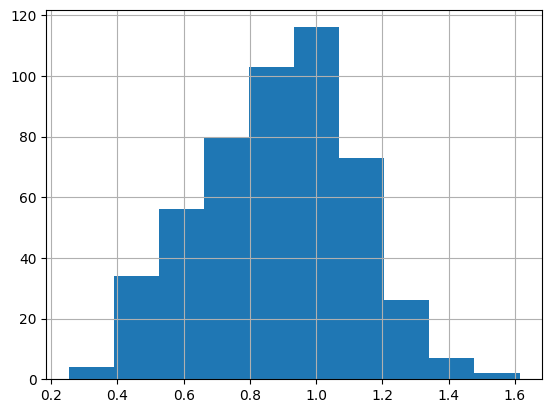

In [109]:
pd.DataFrame(capm_betas)['capm'].hist()